# Investigating the Variability of Spider Light Curves in TESS Fields

Name: Ethan O'Mahony. Student Number: 121382523

This code finds the light curves available for a system from the TESS mission catalog in the MAST database and performs analysis on them.

In [315]:
# Imports necessary libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from astroquery.mast import Observations
from astroquery.mast import Catalogs
from astropy.io import fits
from astropy.timeseries import LombScargle
from scipy import optimize

### Required Inputs from the user:
* The name of the system under investigation: system_name
* Time of pulsar ascending node in TBJD: T0
* The orbital period of the system (use radio if available): system_period

### My systems:

| System Name    | T0 | Radio Orbital Period | 'Spectroscopic Orbital Period |
| :--------: | :-------: | :-------: | :-------: |
| 3FGL J0212.1+5320  | 1487.956799    | 0.8695759(11) [1] |
| 3FGL J0523.3-2528 | -422.5256735    |  | 0.688134(28) [2]|

### Required Initial Parameters

In [316]:
# Required initial parameters for the system
system_name = "3FGL J0212.1+5320"
T0 = 1487.956799

# Choose radio_period if available (more accurate)
system_period = 0.8695759

### Obtaining the File for the System

Occasionally running the cell to query the database times out, but running it again fixes the issue. (Seemingly just internet speed dependent).

In [317]:
# Searches the TESS mission catalog within the MAST database for the system, with a window of radius 0.2 degrees
observations = Observations.query_object(system_name, radius = "0.2 deg")

# Creates a filter to get the obs_id and target_name (TIC ID) for the system
obs_wanted = ( (observations['dataproduct_type'] == 'timeseries') & (observations['obs_collection'] == 'TESS') )

print(observations[obs_wanted]['obs_id','target_name'])

                     obs_id                     target_name
----------------------------------------------- -----------
tess2019306063752-s0018-0000000250704264-0162-s   250704264


Note: If multiple obs_id files are available for your object then you can go through the list by varying $i \in \mathbb{N}$ in observations[obs_wanted]['obs_id'][i]. 
($i=0$ is the first file).

In [318]:
# Builds the link for obtaining the fits file for the light curves 
start_link = 'https://mast.stsci.edu/api/v0.1/Download/file?uri=mast:TESS/product/'
obs_id_str = observations[obs_wanted]['obs_id'].tolist()[0]
end_link = '_lc.fits'

fits_file = start_link + obs_id_str + end_link

In [319]:
# Extracts the data wanted for the light curves from the fits file (hdulist = Header/Data Unit list)
with fits.open(fits_file, mode="readonly") as hdulist:
    tess_bjds = hdulist[1].data['TIME']
    pdcsap_fluxes = hdulist[1].data['PDCSAP_FLUX']
    pdcsap_fluxes_err = hdulist[1].data['PDCSAP_FLUX_ERR']
    
#tess_bjds are the time points for each flux reading in TBJD. 
#pdcsap_fluxes are the flux values, nominally corrected for instrumental variations. 
#pdcsap_fluxes_err are the error values for the flux values

### Removing nan values from the time and flux arrays

In [320]:
#Applies a series of masks to each of the arrays to remove any possible nan values from them
#Flux nans - tidied
mask1 = ~np.isnan(pdcsap_fluxes) 
tidied_flux = pdcsap_fluxes[mask1]
tidied_time = tess_bjds[mask1]
tidied_errors = pdcsap_fluxes_err[mask1]

#Flux error nans - flux_tidied
mask2 = ~np.isnan(tidied_errors) 
flux_tidied_flux = tidied_flux[mask2]
flux_tidied_time = tidied_time[mask2]
flux_tidied_errors = tidied_errors[mask2]

# Time nans - nan_tidied
mask3 = ~np.isnan(flux_tidied_time) 
nan_tidied_flux = flux_tidied_flux[mask3]
nan_tidied_time = flux_tidied_time[mask3]
nan_tidied_errors = flux_tidied_errors[mask3]

### Analysing the Light Curve for Variance

#### Defining some important values:

In [321]:
# Defines some important values for working with the data for the system

P = system_period                         # Defines the period as the orbital period entered at the begining

days_after_T0 = (tess_bjds[0] - T0)       # How many days passed between T0 and TESS's first recording of our system [TBJD]

periods_passed = days_after_T0/P          # How many periods have passed

N = (int(periods_passed))                 # Integer number of periods passed

T0_alt = T0 + N*P                         # Add on the closest integer number of periods to T0 to find the first/nearest 
                                          # pulsar ascending node (phase = 0) available in the observations --> T0_alt (alt standing for alternative) [TBJD]

n_cycles = int(((nan_tidied_time[-1]) - (nan_tidied_time[0])) / P) + 1   # Finds the number of orbital cycles available from the tidied data 

xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'  # x-axis label for a lot of the plots

ylabel = r"Flux [$e^-s^{-1}$]"            # y-axis label for a lot of the plots. [e^-/s]:(electrons per second)

#### Whole Light Curve:

Text(0, 0.5, 'Flux [$e^-s^{-1}$]')

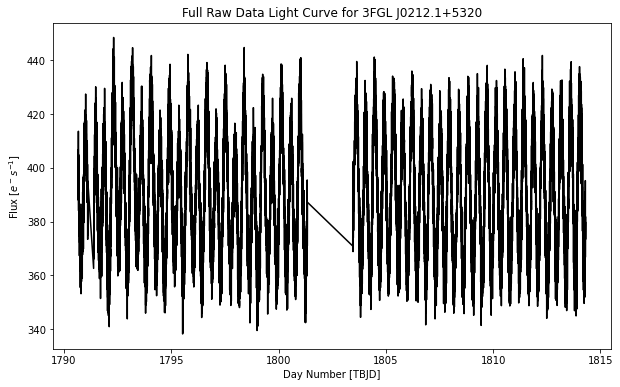

In [322]:
# Plots the full available light curve for the system
plt.figure(figsize=(10, 6))
plt.plot(nan_tidied_time,nan_tidied_flux, color='k')
plt.title("Full Raw Data Light Curve for " + str(system_name))
plt.xlabel("Day Number [TBJD]")
plt.ylabel(ylabel)

#### Waterfall:

Text(0.5, 1.0, 'Waterfall Plot for 3FGL J0212.1+5320')

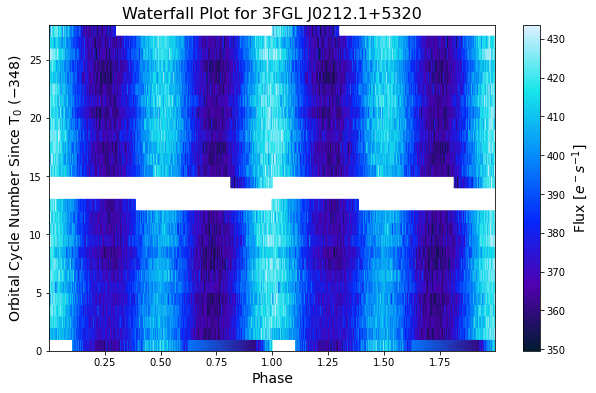

In [323]:
# Calculates the phase in sections of 0 to 1 for each orbital cycle
phase = ((nan_tidied_time - T0_alt) / P) % 1  

# Creates a custom color map for the heatmap (pcolormesh). I found values for the colours of ["blue near black","mid range blue","blue near white"]
#custom_cmap = LinearSegmentedColormap.from_list("custom", ["#011B31", "#058CFB", "#DDF0FF"])
# Then made one with five colours to try and extend the variability of the waterfall. Can't decide which is better. But below has similar colours to the 3-colour one, with the addition of 2 darker colours, and one lighter.
custom_cmap = LinearSegmentedColormap.from_list("custom", ["#011B31", "#5001AF" , "#0528FB" ,"#058CFB", "#16E5EA","#DDF0FF"])


plt.figure(figsize=(10, 6))


# Creates a mask with the time stamps of each cycle number. Stacks each cycle on top of each other in "Waterfall" Plot
for cycle in range(n_cycles):                      
    start_time = T0_alt + cycle * P                 
    end_time = T0_alt + (cycle + 1) * P
    mask = (nan_tidied_time >= start_time) & (nan_tidied_time < end_time)    
    phase_cycle = phase[mask]                                 
    flux_cycle = nan_tidied_flux[mask]
    
    # Ensures that flux_cycle with enirely nan values are "ignored" (not doing this occasionally caused problems, but an empty orbital cycle will be plot on the waterfall still so it is fine to do as a precaution)
    if len(flux_cycle > 0):
        plt.pcolormesh(phase_cycle,[cycle,cycle+1.0],[flux_cycle,flux_cycle],cmap=custom_cmap, shading='gouraud')  #Plots phase 0-1
        plt.pcolormesh(phase_cycle+1,[cycle,cycle+1.0],[flux_cycle,flux_cycle],cmap=custom_cmap,shading='gouraud') #Plots phase "1-2" 


# Creates the waterfall plot
cbar = plt.colorbar()
cbar.set_label(ylabel, size=14)
plt.xlabel('Phase', size=14)
plt.ylabel(xlabel, size=14)
plt.title('Waterfall Plot for ' + str(system_name), size=16)

#### Plotting the Light Curves for Some of the Orbital Cycles (2-6) with Errors:

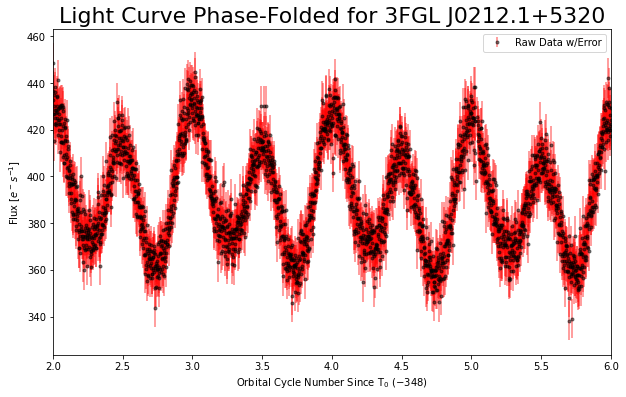

In [324]:
# Phase folds the data into orbital cycles measured in N.0 to (N+1).0 for N in n_cycles. 
phase = ((nan_tidied_time - T0_alt) / P)

phases = []
fluxes = []
errors = []
cycles = []

for cycle in range(n_cycles):                      
    start_time = T0_alt + cycle * P                 
    end_time = T0_alt + (cycle + 1) * P
    mask = (nan_tidied_time >= start_time) & (nan_tidied_time < end_time)    
    phase_cycle = phase[mask]                                 
    flux_cycle = nan_tidied_flux[mask]
    error_cycle = nan_tidied_errors[mask]
    phases = np.append(phases,phase_cycle)
    fluxes = np.append(fluxes,flux_cycle)
    errors = np.append(errors,error_cycle)
    cycles = np.append(cycles,cycle)
    

plt.figure(figsize=(10, 6))
plt.errorbar(phases, fluxes, yerr=errors, fmt='k.', ecolor='r', label="Raw Data w/Error", alpha=0.5)
plt.title("Light Curve Phase-Folded for " + str(system_name), size=22)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(cycles[2],cycles[6])
plt.legend()

### Lomb-Scargle Periodogram Testing the Orbital Period

In [325]:
# Performs a Lomb-Scargle Periodogram (LSP) on the data to get an approximation of the period of the system
frequency, power = LombScargle(nan_tidied_time, nan_tidied_flux, nterms=2).autopower(samples_per_peak=20,maximum_frequency=1/(5/(60*24) ))

# LombScargle() [3][4]

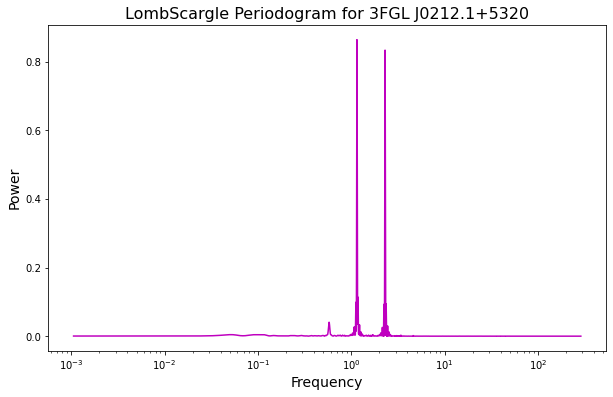

In [326]:
#Plot of the power vs frequency found from the LSP
plt.figure(figsize=(10, 6))
plt.title("LombScargle Periodogram for " + system_name, size = 16)
plt.plot(frequency,power, label = "Frequency vs Power",color='m')
plt.xlabel("Frequency", size = 14)
plt.ylabel("Power", size = 14)
plt.xscale('log')
plt.savefig("J0523LombScargle.pdf")

In [327]:
# Finds the initial approximation for the period of the system from the max power found by the LSP
max_index = np.argmax(power)
max_frequency = frequency[max_index]
B1 = 1/max_frequency
print("Period Initial Guess:",B1)

Period Initial Guess: 0.8701290470673908


### Fitting an Optimised Double Sine Function to the Data
#### Fitting a model to the entire data set:

Fitted parameters: A=5.871819106561836, B=0.869581529224953, C=0.675916502017401, D=28.096445914526242, E=0.0777594949313451, F=389.4110697377842 

Reduced χ2: 0.8728807716906168 



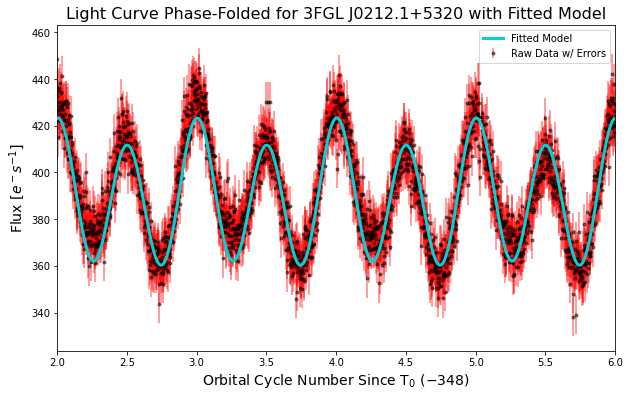

In [328]:
# Test function to build a model approximating the data. The function is of the form sine(With Period P) + sine(With Period (P/2))

# f = (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

# A is the amplitude of the first harmonic. B is the period.
# C is the phase offset of the first harmonic. D is the amplitide of the second harmonic.
# E is the phase offset of the second harmonic. F shifts the central y-axis value of the test function up to the average 
# flux of the data set.

# Defines the test function that the model will approximate
def test_func(x, A, B, C, D, E, F):
    return (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

#Number of varying parameters in the model
num_params = 6

#Initial guesses for the parameters of the model
averageflux = np.mean(nan_tidied_flux)
A = 4
B = P 
C = 1
D = 16
E = 1
F = averageflux

# Assigning our initial guesses for the parameters into an array
init_vals = [A,B,C,D,E,F]


#Uses our test function with scipy's optimize.curve_fit to create a model for the dataset                                                                ###Bounds broke this model and any single sine models to follow for some reason (worked here occasionally if it was in the mood)
params, params_covariance = optimize.curve_fit(test_func, nan_tidied_time, nan_tidied_flux, init_vals, nan_tidied_errors) #,bounds = ([0,0,-np.pi,0,-np.pi,0],[np.inf,np.inf,np.pi,np.inf,np.pi,np.inf]))


# Extracts the parameter fit values and covariance matrix values for each parameter
A_fit, B_fit, C_fit, D_fit, E_fit, F_fit = params
A_cov, B_cov, C_cov, D_cov, E_cov, F_cov = params_covariance

print(f"Fitted parameters: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit}, E={E_fit}, F={F_fit} \n")

# Uses the best fit parameters to create the test model
y_fit = test_func(nan_tidied_time, A_fit, B_fit, C_fit, D_fit, E_fit, F_fit)

# Finds the reduced chi**2 value for the test model
r_chi_squared = (np.sum(((fluxes-y_fit)/(errors))**2))/(len(y_fit)-num_params)
print("Reduced \u03C72:",r_chi_squared,"\n")

# Plots the tidied data with errorbars vs time, and the model vs time
plt.figure(figsize=(10, 6))
plt.errorbar(phases, fluxes, yerr=errors, fmt='k.', ecolor = 'r', label="Raw Data w/ Errors", alpha=0.5)
plt.plot(phases,y_fit,label="Fitted Model", lw=3, color='#02D1D6', zorder=5)
plt.legend()
plt.title("Light Curve Phase-Folded for " + str(system_name) + " with Fitted Model", size=16)
plt.xlabel(xlabel, size=14)
plt.ylabel(ylabel, size=14)
plt.xlim(cycles[2],cycles[6])
plt.xlim()
plt.savefig("J0212LCwModel.pdf")

In [329]:
# Propagation of errors formula to get the error of the model from the covariance matrices

# The function f:
# f = (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

# Values of our parameters
x = nan_tidied_time
A = A_fit
B = B_fit
C = C_fit
D = D_fit
E = E_fit 
F = F_fit

# Partial derivatives of f. where f (the fit) diffrentiated with respect to A is represented as: fwA, etc.
fwA = np.sin(2*np.pi/B * x + C)  
fwB = -((2*np.pi*x*(2*E*np.cos(4*np.pi/B * x + F) + A*np.cos(2*np.pi/B * x + C)))/(B**2))
fwC = A*np.cos(2*np.pi/B * x + C)
fwD = 1
fwE = np.sin(4*np.pi/B * x + F)
fwF = E*np.cos(4*np.pi/B * x + F)

# Propagation of errors formula
y_fit_err = np.sqrt( (fwA**2)*(A_cov[0]) + (fwB**2)*(B_cov[1]) + (fwC**2)*(C_cov[2]) + (fwD**2)*(D_cov[3]) + (fwE**2)*(E_cov[4]) + (fwF**2)*(F_cov[5]) + 2*fwA*fwB*(A_cov[1]) + 2*fwA*fwC*(A_cov[2]) + 2*fwA*fwD*(A_cov[3]) + 2*fwA*fwE*(A_cov[4]) + 2*fwA*fwF*(A_cov[5]) + 2*fwB*fwC*(B_cov[2]) + 2*fwB*fwD*(B_cov[3]) + 2*fwB*fwE*(B_cov[4]) + 2*fwB*fwF*(B_cov[5]) + 2*fwC*fwD*(C_cov[3]) + 2*fwC*fwE*(C_cov[4]) + 2*fwC*fwF*(C_cov[5]) + 2*fwD*fwE*(D_cov[4]) + 2*fwD*fwF*(D_cov[5]) + 2*fwE*fwF*(E_cov[5]))

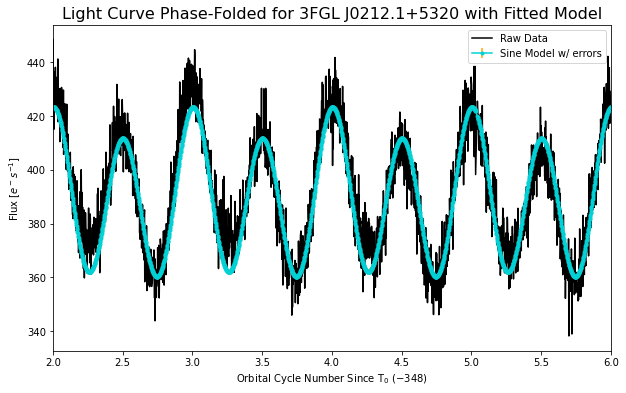

In [330]:
# Plots the model with errorbars and the tidied data vs time
plt.figure(figsize=(10, 6))
plt.errorbar(phases, y_fit, y_fit_err, color='#02D1D6', marker='.', ecolor = 'orange', label = "Sine Model w/ errors") # Place 3* in front of the y_fit_err to check the errors to the 3 sigma level
plt.plot(phases, fluxes, color='k', label="Raw Data")
plt.title("Light Curve Phase-Folded for " + str(system_name) + " with Fitted Model", size=16)
plt.xlabel(xlabel)
plt.ylabel(ylabel)
plt.xlim(cycles[2],cycles[6])
plt.legend()

#### Fitting a Model to Each Phase of the Data Individually:

This one just shows plots with the full model.

Cycle Number: 1 

Fitted parameters: A=16.04580787524386, B=0.8696927295938526, C=0.614612015259718, D=27.746554030508506, E=3.1415925944097327, F=378.4282270306549

Reduced χ2: 0.714132754497453 



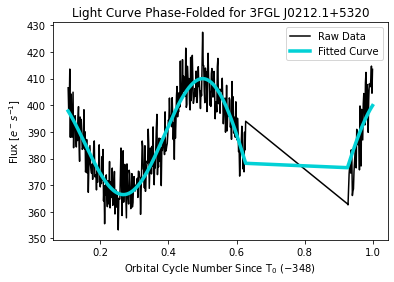

Cycle Number: 2 

Fitted parameters: A=9.242942795782639, B=0.8694693345797812, C=-1.2232774791465544, D=27.46723075894576, E=-3.1415922727722334, F=388.20255504160644

Reduced χ2: 0.8441397243694314 



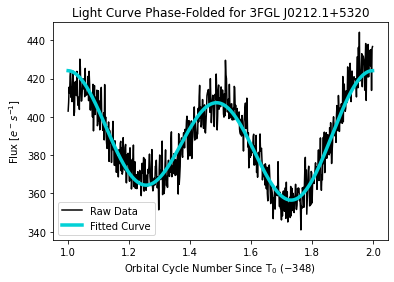

Cycle Number: 3 

Fitted parameters: A=9.47202630035107, B=0.8696812277267393, C=1.8496882598520148, D=28.264881227458723, E=3.1415926454403666, F=393.9063944796696

Reduced χ2: 0.6739378956089948 



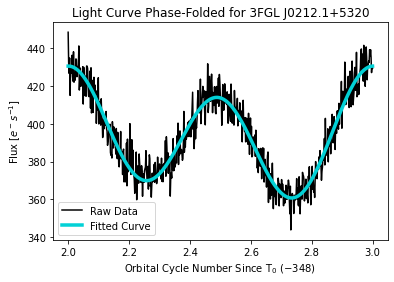

Cycle Number: 4 

Fitted parameters: A=9.621047267428219, B=0.869682922800016, C=1.824767313725239, D=27.231462749234517, E=3.1415926514824877, F=392.64094987354196

Reduced χ2: 0.656356927538301 



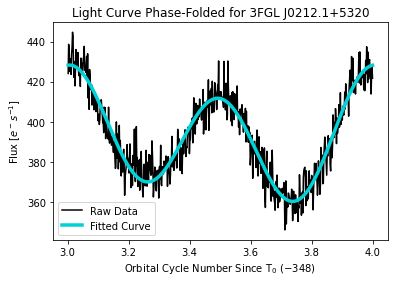

Cycle Number: 5 

Fitted parameters: A=10.681151741632448, B=0.8694739636111076, C=-1.289088465999078, D=26.82422125767968, E=-3.1415926299876697, F=389.8773391361055

Reduced χ2: 0.7281459364662966 



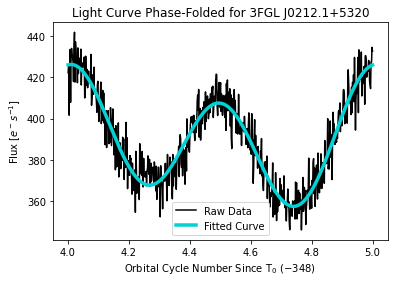

Cycle Number: 6 

Fitted parameters: A=9.442277330849546, B=0.8696834097337378, C=2.0644690683729996, D=25.525623416225866, E=3.1415908299620856, F=388.6617300810903

Reduced χ2: 0.6960754742189756 



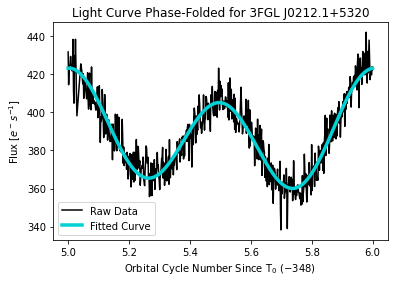

Cycle Number: 7 

Fitted parameters: A=9.139473462233521, B=0.8694737456124167, C=-1.0398189511705749, D=26.726026855316984, E=-3.1415911417704363, F=389.58072976381237

Reduced χ2: 0.6482862343671675 



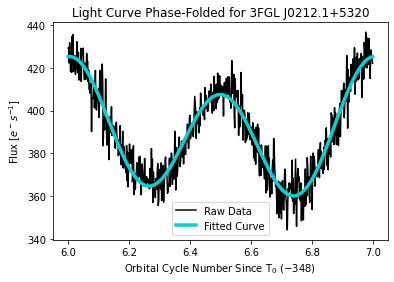

Cycle Number: 8 

Fitted parameters: A=10.071223609971591, B=0.869684192774503, C=2.1934709122323577, D=27.398156666147212, E=3.1415911317626737, F=389.5898067414328

Reduced χ2: 0.6793544230854962 



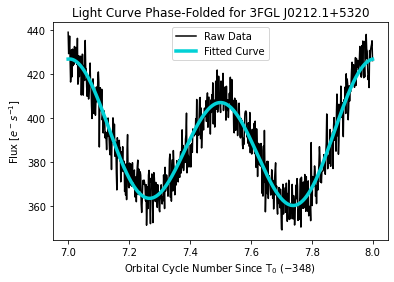

Cycle Number: 9 

Fitted parameters: A=9.242984326525079, B=0.8696844900268346, C=2.223709790534463, D=27.02029662046507, E=3.1415906317044717, F=388.1074294327389

Reduced χ2: 0.5946590925284541 



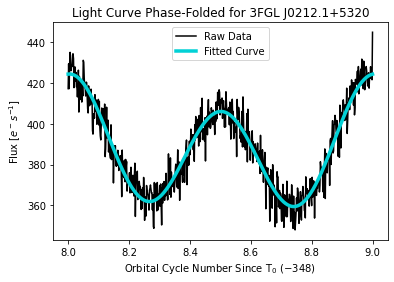

Cycle Number: 10 

Fitted parameters: A=9.915756129953461, B=0.869686370810166, C=2.0704909273298653, D=28.225439930641002, E=3.1415925432504195, F=384.9165870984035

Reduced χ2: 0.8047240459683145 



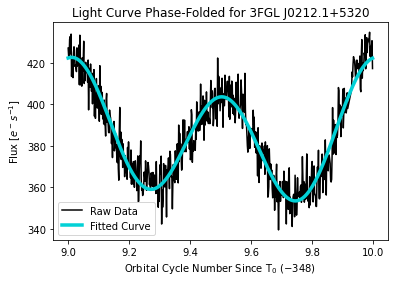

Cycle Number: 11 

Fitted parameters: A=8.338718721861252, B=0.8696845758684992, C=2.293377911276952, D=27.57040730721431, E=3.1415902442622214, F=388.13096287127144

Reduced χ2: 0.5916925864520716 



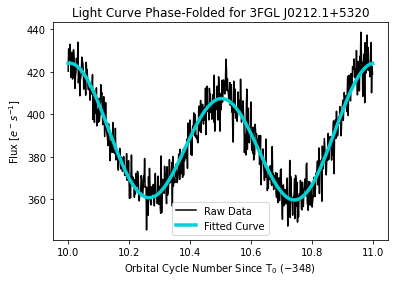

Cycle Number: 12 

Fitted parameters: A=7.893018844721566, B=0.8696844612035434, C=2.4454651305025723, D=26.95815489091014, E=3.1415912905969434, F=390.4797804523643

Reduced χ2: 0.6394171662196684 



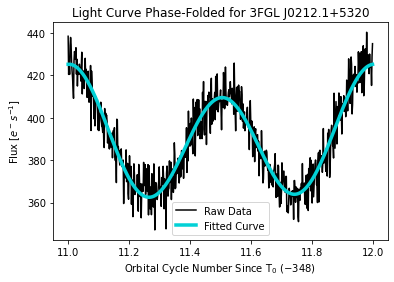

Cycle Number: 13 

Fitted parameters: A=68.96349041217306, B=0.8696053571229947, C=2.9092333064009552, D=14.204043927796953, E=-0.4269723991303384, F=435.9092656738743

Reduced χ2: 0.6301594686180566 



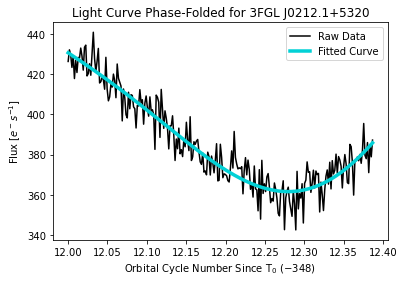

Cycle Number: 14 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000, for cycle number: 14 



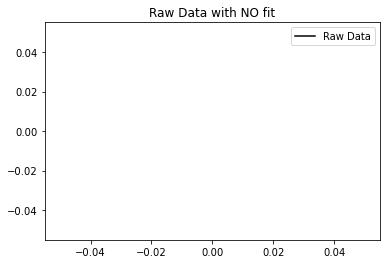

Cycle Number: 15 

Fitted parameters: A=554.0843517630117, B=0.8696841441191664, C=3.103393685719761, D=164.48207596241235, E=1.6390340831175314, F=3.4581823861331267

Reduced χ2: 0.5000588639808705 



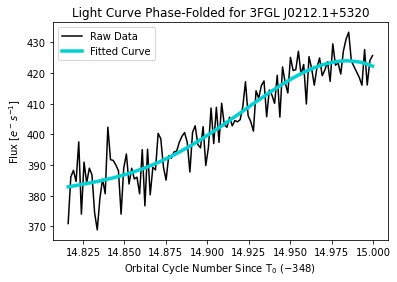

Cycle Number: 16 

Fitted parameters: A=6.258545224268353, B=0.8694759088928479, C=-0.8093740356945464, D=29.96793933281793, E=-3.1415926528836495, F=389.5816722639787

Reduced χ2: 0.682056985379684 



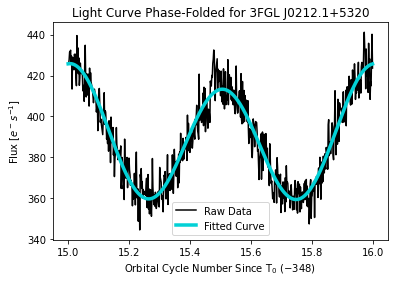

Cycle Number: 17 

Fitted parameters: A=4.72460982927219, B=0.8696844814237189, C=2.347711612144031, D=28.066396816347314, E=3.141590811759242, F=392.5852025096708

Reduced χ2: 0.6493935033491886 



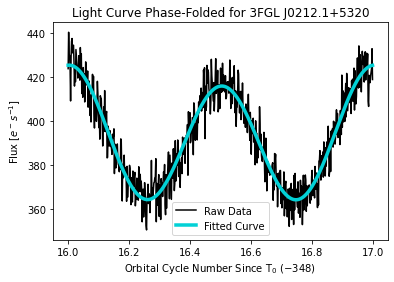

Cycle Number: 18 

Fitted parameters: A=4.841351026473583, B=0.8696857027209307, C=2.2741062149397275, D=28.46029017168008, E=3.141592597379153, F=390.58467818465897

Reduced χ2: 0.5910078425082467 



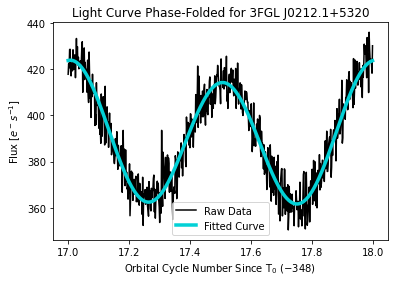

Cycle Number: 19 

Fitted parameters: A=5.152515689640986, B=0.869475646536202, C=-0.7032096805039, D=28.60555690804367, E=-3.141591945182913, F=389.0330973851288

Reduced χ2: 0.6016940619237556 



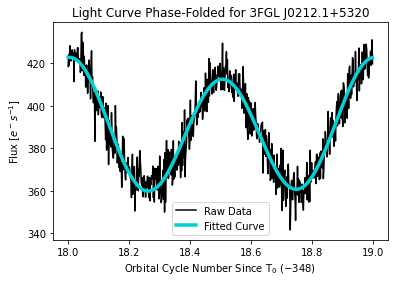

Cycle Number: 20 

Fitted parameters: A=3.7056130612636906, B=0.869684725600983, C=2.346630077228672, D=29.30365612924511, E=3.1415895189622067, F=388.2478974504822

Reduced χ2: 0.671458815115196 



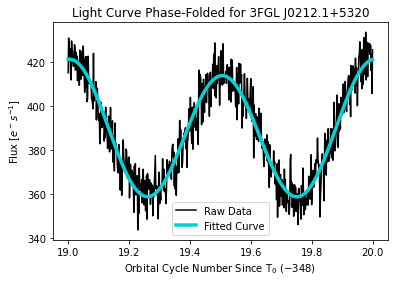

Cycle Number: 21 

Fitted parameters: A=3.8023024793634086, B=0.8696841859557447, C=3.0096614806957964, D=29.560330077745938, E=3.14159264730963, F=386.09769793163076

Reduced χ2: 0.5727799477970612 



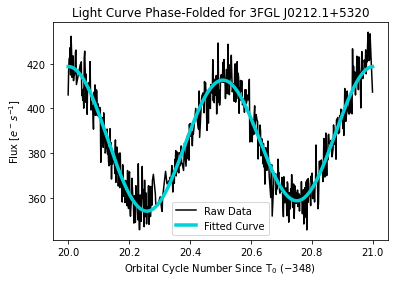

Cycle Number: 22 

Fitted parameters: A=2.8519501382435224, B=0.869683741497058, C=2.8963019383583757, D=30.03315834537374, E=3.1415926331758786, F=388.56803536890726

Reduced χ2: 0.6797334406910195 



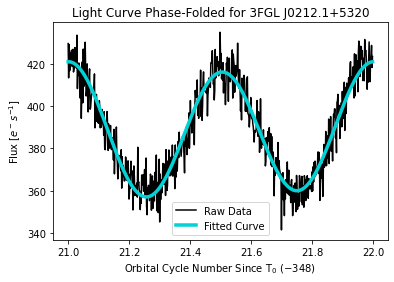

Cycle Number: 23 

Fitted parameters: A=2.750714361405227, B=0.8696830494262373, C=2.8504636637551073, D=30.144001218525474, E=3.141592651455777, F=389.9948105883286

Reduced χ2: 0.6547185434924973 



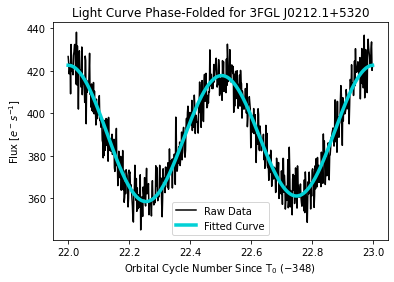

Cycle Number: 24 

Fitted parameters: A=2.763543837751219, B=0.8696705289349035, C=3.1415926513541175, D=30.135257227422127, E=2.7516179617159473, F=389.8010137360909

Reduced χ2: 0.6101958664763056 



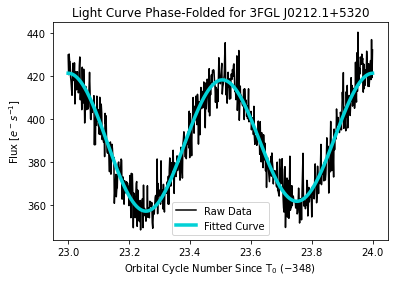

Cycle Number: 25 

Fitted parameters: A=1.993210433204224, B=0.869683211601881, C=2.9113212429281825, D=29.761305229368777, E=3.1415926530588814, F=389.7592299136417

Reduced χ2: 0.6037465082126668 



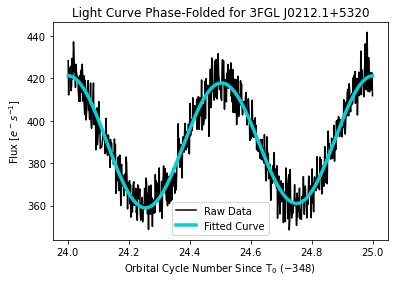

Cycle Number: 26 

Fitted parameters: A=2.7050620487267927, B=0.8696825376846834, C=2.9115747361925997, D=30.25177731084064, E=3.1415926535536975, F=388.75069521634737

Reduced χ2: 0.6549907168548038 



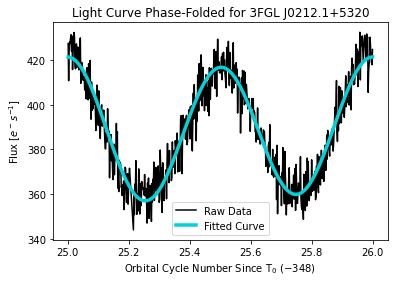

Cycle Number: 27 

Fitted parameters: A=2.693928533192482, B=0.8696194975074333, C=3.1415913758551453, D=30.5783895344091, E=1.2790322483749053, F=391.1236141229858

Reduced χ2: 0.7139284171603131 



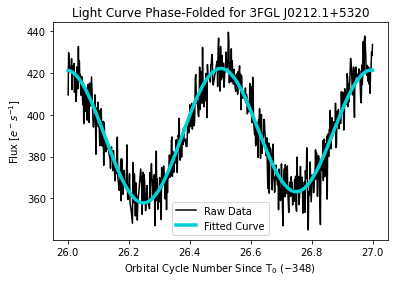

Cycle Number: 28 

Fitted parameters: A=188.74285776465862, B=0.8695764939730245, C=-0.27105090078053845, D=84.7218390601164, E=0.7635613241579384, F=265.56166331850534

Reduced χ2: 0.8330598630694924 



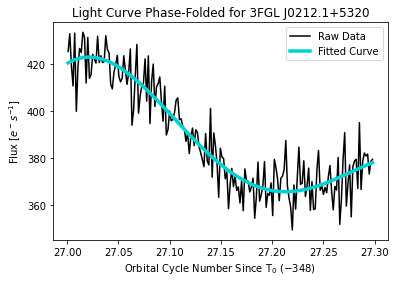

In [331]:
#Defining the test function
def test_func(x, A, B, C, D, E, F):
    return (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

# Initial Values
A = 4 
B = P
C = 1 
D = 16 
E = 1 
F = averageflux 

init_vals = [A,B,C,D,E,F]

# Creates an array to store the reduced chi square values
reduced_chi_squared = []

phase = ((nan_tidied_time - T0_alt) / P) 

# Loops through each orbital cycle available in the data
for cycle in range(n_cycles):
    # Try and Except present as precaution for any data section that optimize.curve_fit can't find optimal parameters for
    try:
        # Selects section of data to analyse
        start = T0_alt + cycle*P
        end = T0_alt + (cycle + 1)*P
        mask = (nan_tidied_time >= start) & (nan_tidied_time < end)
        
        #Creates the arrays for this phase from our nan_tidied data (s_ stands for section)
        s_nan_tidied_time = nan_tidied_time[mask]
        s_nan_tidied_flux = nan_tidied_flux[mask]   
        s_nan_tidied_errors = nan_tidied_errors[mask]
        phase_cycle = phase[mask]                                 
    
        #Uses our test function with scipy's optimize.curve_fit to create a model for this orbital cycle
        params, params_covariance = optimize.curve_fit(test_func, s_nan_tidied_time, s_nan_tidied_flux, init_vals, s_nan_tidied_errors,maxfev=10000, bounds = ([0,0,-np.pi,0,-np.pi,0],[np.inf,np.inf,np.pi,np.inf,np.pi,np.inf]) )
        s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit = params
        

        #Prints out the cycle number (since T0_alt) and the fit parameters 
        print("Cycle Number:",cycle+1,"\n")
        print(f"Fitted parameters: A={s_A_fit}, B={s_B_fit}, C={s_C_fit}, D={s_D_fit}, E={s_E_fit}, F={s_F_fit}\n")
    
        #Creates an array for the test model
        y_fit = test_func(s_nan_tidied_time, s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit)
        
        #Finds the reduced chi**2 of the model
        r_chi_squared = (np.sum(((s_nan_tidied_flux-y_fit)/(s_nan_tidied_errors))**2))/(len(y_fit)-num_params)
        reduced_chi_squared = np.append(reduced_chi_squared, r_chi_squared)
        print("Reduced \u03C72:",r_chi_squared,"\n")
        
        
        #Plots the time vs flux of the real data, and the time vs the model data
        plt.plot(phase_cycle, s_nan_tidied_flux, label="Raw Data", color='k')
        plt.plot(phase_cycle, y_fit, label="Fitted Curve", color='#02D1D6', lw=3.5)
        plt.xlabel(xlabel)
        plt.ylabel(ylabel)
        plt.title("Light Curve Phase-Folded for " + str(system_name))
        plt.legend()
        plt.show()
        
        
    except:
        # Except case for any optimize.curve_fit that can't find optimal parameters 
        print("Cycle Number:",cycle+1,"\n")
        print("RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000, for cycle number:",cycle+1,"\n")

        # Keeps r_c_s array the same length as array it will be plot with 
        reduced_chi_squared = np.append(reduced_chi_squared, 0)
        
        # Plots the real data for the phase        
        plt.plot(phase_cycle, s_nan_tidied_flux, label="Raw Data", color='k')
        plt.title("Raw Data with NO fit")
        plt.legend()
        plt.show()


This one also plots each of the harmonics separately if you want a more in depth look at whats happening.

Phase Number: 1 

Fitted parameters: A=16.04475921898436, B=0.8697983198924619, C=2.186068074405257, D=27.752109048344316, E=6.283184314965197, F=378.4320165675102

Reduced χ2: 0.7140127867778069 



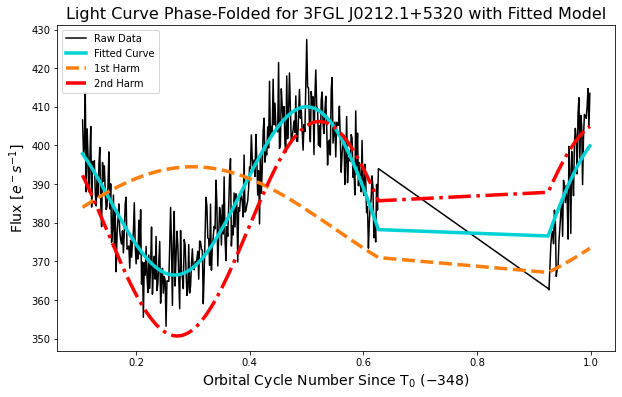

Phase Number: 2 

Fitted parameters: A=9.251102833333963, B=0.8695748179882901, C=0.347992199449878, D=27.46817575110953, E=2.8512526316439055e-08, F=388.2068894770013

Reduced χ2: 0.8442133814808558 



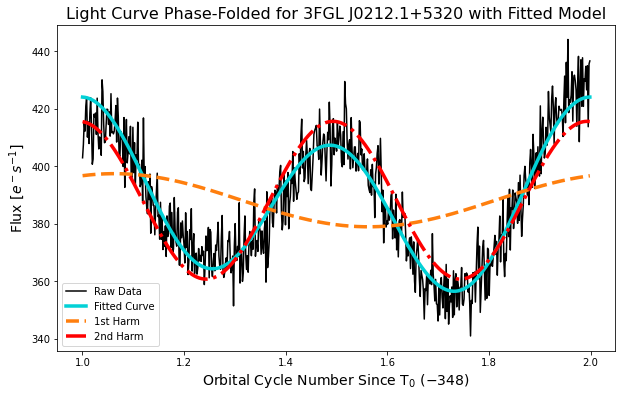

Phase Number: 3 

Fitted parameters: A=9.480292698485824, B=0.8697867125004616, C=3.420999762989886, D=28.2660181305072, E=6.2831853059941505, F=393.91080559289543

Reduced χ2: 0.6739045826429316 



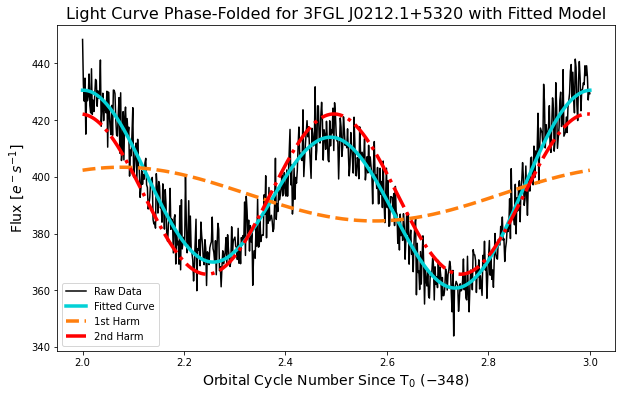

Phase Number: 4 

Fitted parameters: A=9.628998052174385, B=0.8697883570419571, C=3.3960651754826876, D=27.23264172231017, E=6.283185303775413, F=392.6452584426635

Reduced χ2: 0.6562927600038955 



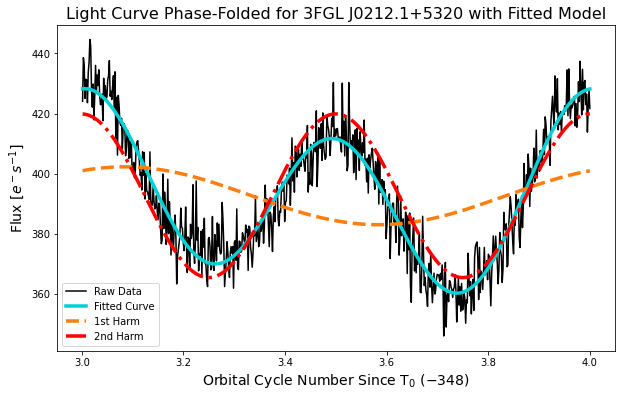

Phase Number: 5 

Fitted parameters: A=10.689125650526687, B=0.8695792958725377, C=0.2821347839044995, D=26.82513622623464, E=5.729915509470831e-10, F=389.8817223433799

Reduced χ2: 0.7281658075568191 



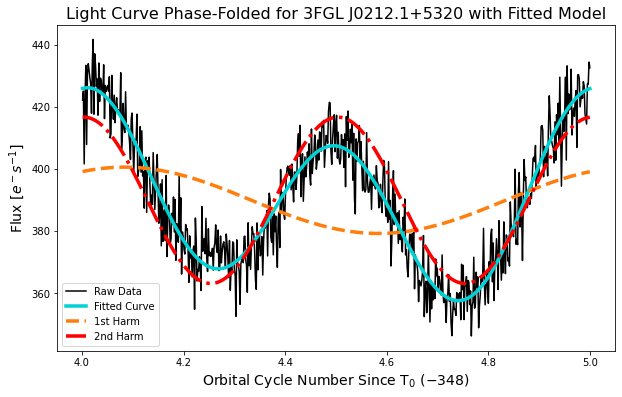

Phase Number: 6 

Fitted parameters: A=9.450710174823891, B=0.8697887413426889, C=3.635553652284932, D=25.526143210888925, E=6.283181132187046, F=388.66598542009547

Reduced χ2: 0.6960531063227062 



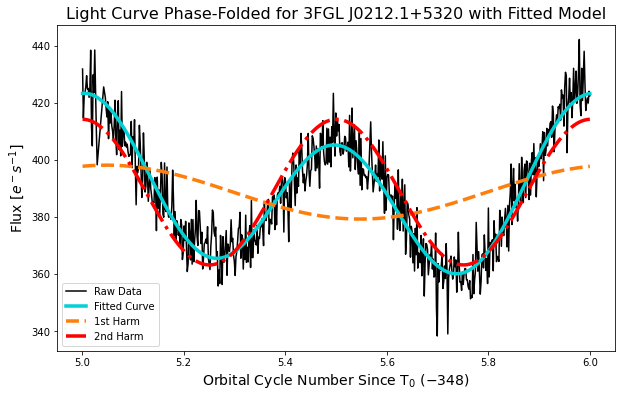

Phase Number: 7 

Fitted parameters: A=9.148284961006855, B=0.8695789759058749, C=0.5312431549930801, D=26.726871539114466, E=2.2259062001145163e-08, F=389.5850283465159

Reduced χ2: 0.6483190518861638 



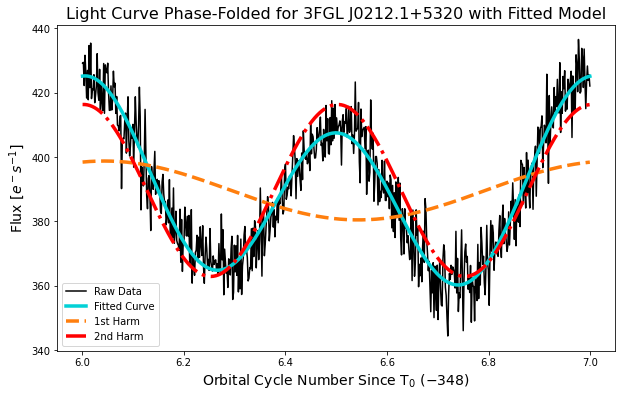

Phase Number: 8 

Fitted parameters: A=10.080508506217155, B=0.8697894233336947, C=3.764434447564082, D=27.39862680219016, E=6.28318522800852, F=389.5943256623948

Reduced χ2: 0.679301927565398 



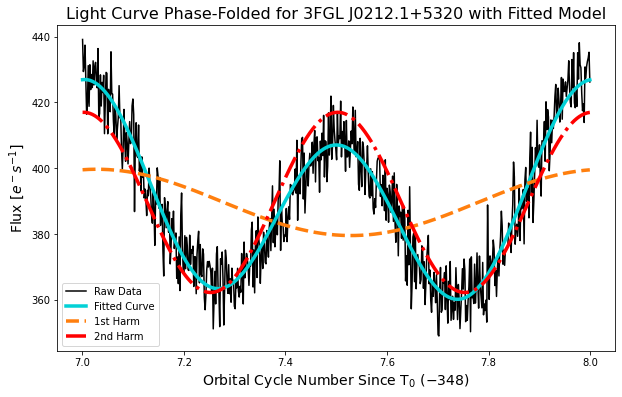

Phase Number: 9 

Fitted parameters: A=9.252005971138653, B=0.8697896696957725, C=3.7946487212612516, D=27.01920158855467, E=6.283185249188879, F=388.1118038600069

Reduced χ2: 0.594633258777846 



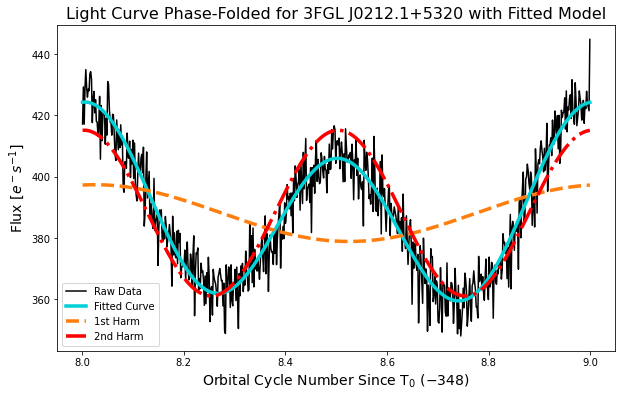

Phase Number: 10 

Fitted parameters: A=9.924887642405753, B=0.8697914990963981, C=3.641576083272995, D=28.226591075541343, E=6.283179943449213, F=384.9210845597573

Reduced χ2: 0.8046050392719207 



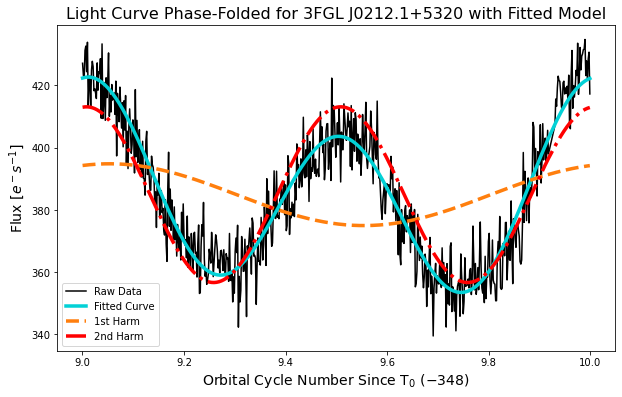

Phase Number: 11 

Fitted parameters: A=8.348067154012758, B=0.8697896539912897, C=3.864259623398045, D=27.570820002734834, E=6.283184326254007, F=388.1353001459312

Reduced χ2: 0.591665760150423 



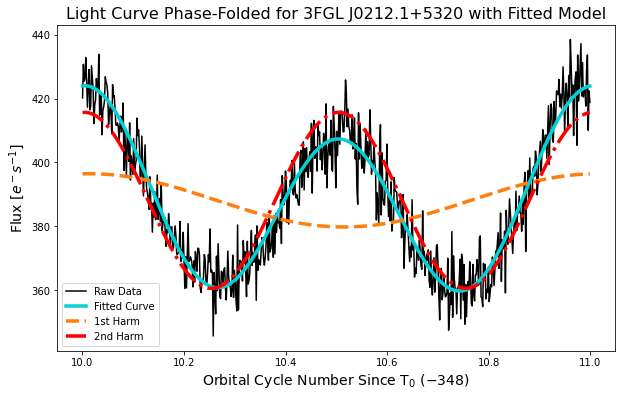

Phase Number: 12 

Fitted parameters: A=7.902037190433213, B=0.8697894890371228, C=4.016157562378778, D=26.95698871611556, E=6.283185295335658, F=390.48399076020917

Reduced χ2: 0.6393842912377794 



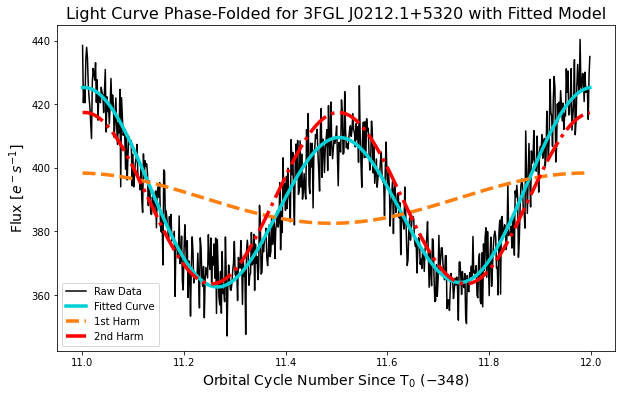

Phase Number: 13 

Fitted parameters: A=68.96577007449723, B=0.8696234946583874, C=3.1806879148659357, D=14.204944950980313, E=0.11590551946030994, F=435.91171807220235

Reduced χ2: 0.6301595359468642 



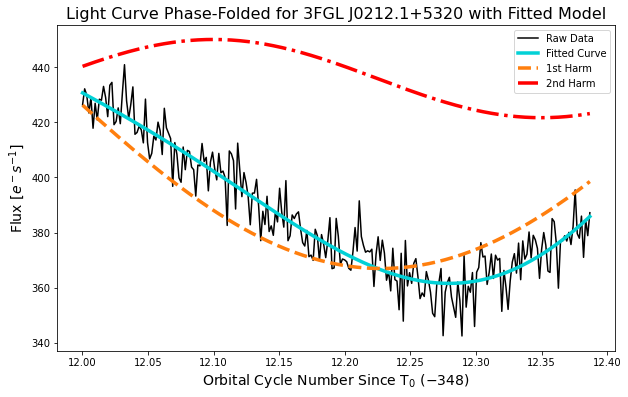

Phase Number: 14 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000, for cycle number: 14 



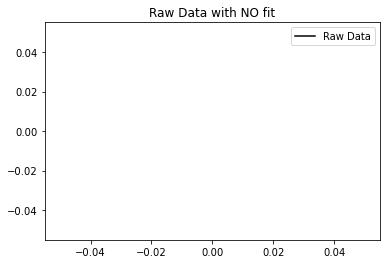

Phase Number: 15 

Fitted parameters: A=0.011574766105557079, B=0.8696271571351499, C=1.5449656096273747, D=25.242798994869847, E=0.9858569364186072, F=405.23129273291454

Reduced χ2: 0.5274746719472466 



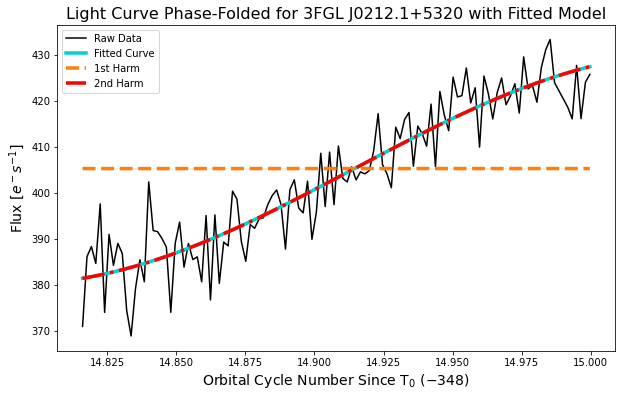

Phase Number: 16 

Fitted parameters: A=6.268470698896324, B=0.8695806838633358, C=0.7614815875444416, D=29.96913670046954, E=7.835571185507158e-06, F=389.5859537436283

Reduced χ2: 0.6820652866023197 



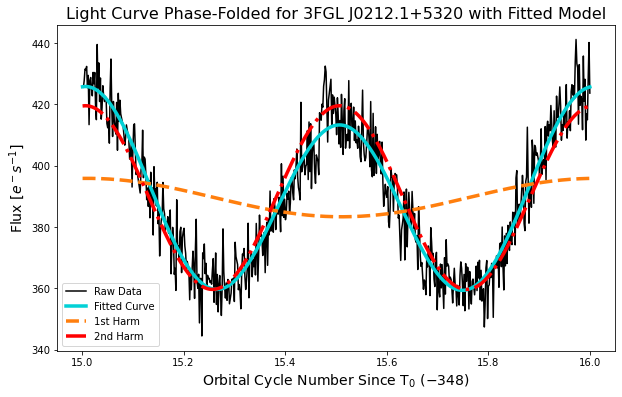

Phase Number: 17 

Fitted parameters: A=4.733667800358519, B=0.869789252771021, C=3.9184379268795357, D=28.061288633461167, E=6.283078741555865, F=392.589170072395

Reduced χ2: 0.6493830795167898 



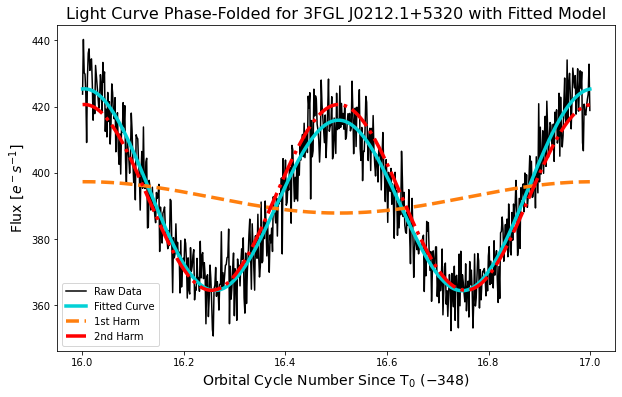

Phase Number: 18 

Fitted parameters: A=4.85071829682985, B=0.8697904268131631, C=3.8450825468559637, D=28.461625144085726, E=6.283185263448701, F=390.5886587493882

Reduced χ2: 0.5909895731827887 



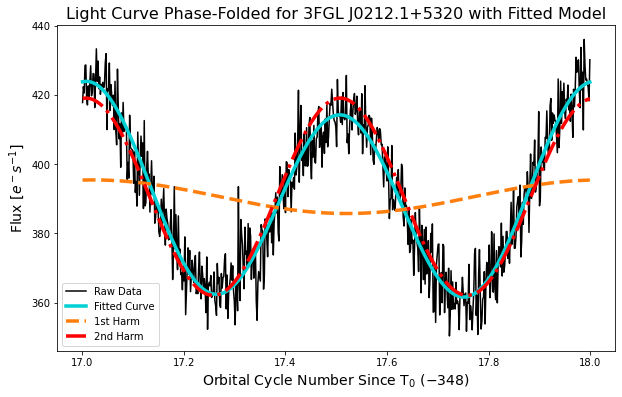

Phase Number: 19 

Fitted parameters: A=5.1619971024473035, B=0.8695802883228032, C=0.8677052104103612, D=28.606840612810938, E=0.0005458847763585284, F=389.0371519367389

Reduced χ2: 0.6017036309053827 



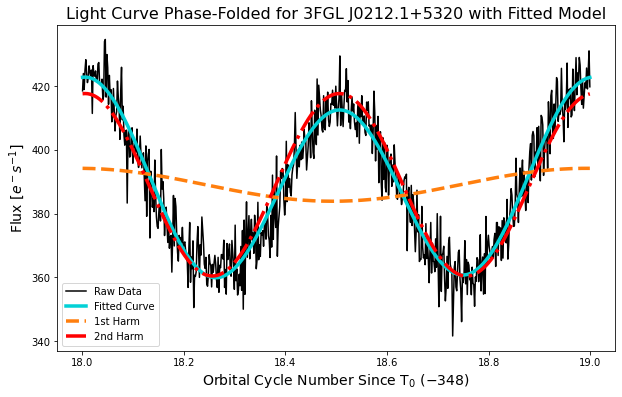

Phase Number: 20 

Fitted parameters: A=3.715278298276123, B=0.8697893487652496, C=3.917486238851088, D=29.305208233968678, E=6.2831837886741795, F=388.25186455359005

Reduced χ2: 0.6714268190452165 



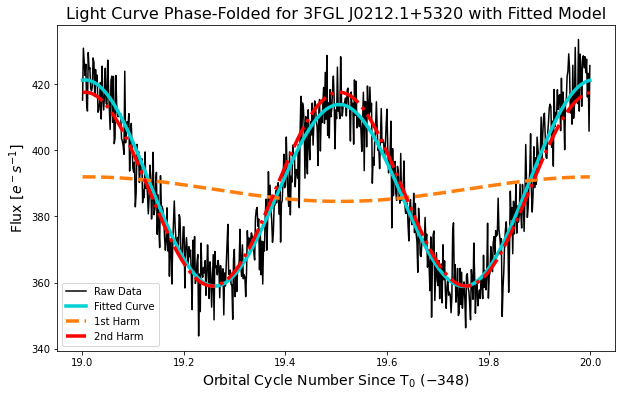

Phase Number: 21 

Fitted parameters: A=3.809866025415081, B=0.8697887590566185, C=4.578824531667724, D=29.562086462052402, E=6.283185302527456, F=386.10196884232823

Reduced χ2: 0.5726824185776179 



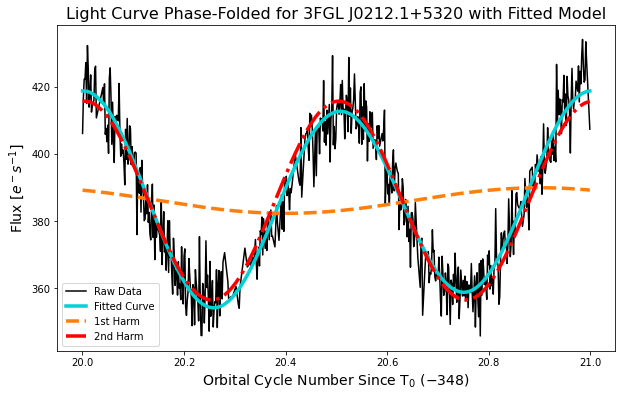

Phase Number: 22 

Fitted parameters: A=2.8604665456109464, B=0.8697882639399795, C=4.465366726120102, D=30.03483867080586, E=6.283185306268938, F=388.5719357991316

Reduced χ2: 0.6796930620154592 



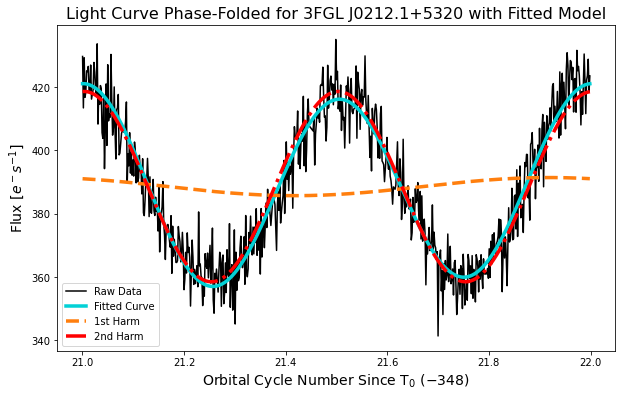

Phase Number: 23 

Fitted parameters: A=2.759451863812596, B=0.8697875220216175, C=4.4195714011733545, D=30.145953099020467, E=6.283185302422172, F=389.99872201208865

Reduced χ2: 0.6545959271951685 



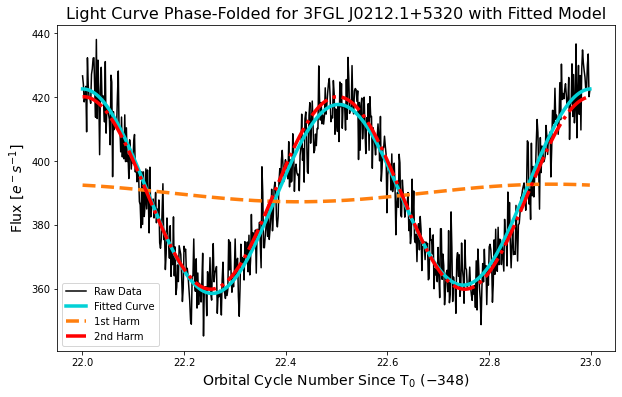

Phase Number: 24 

Fitted parameters: A=2.7697268524422753, B=0.8697879118676548, C=4.904563421689125, D=30.137330797445802, E=6.283185301400282, F=389.8052760409305

Reduced χ2: 0.6101072837389394 



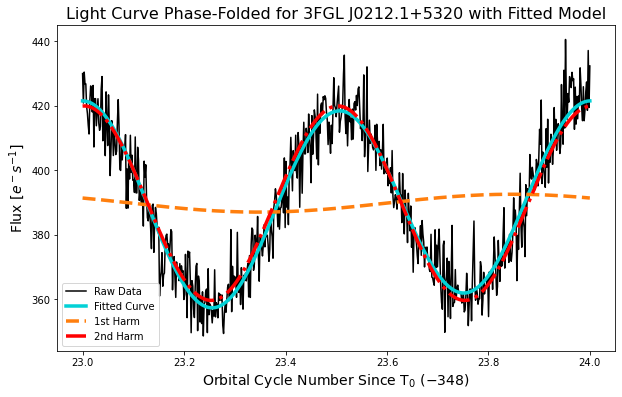

Phase Number: 25 

Fitted parameters: A=2.0014670210251335, B=0.8697875838702747, C=4.479571726972046, D=29.76301317189062, E=6.283185307179529, F=389.76301250902713

Reduced χ2: 0.603705378435675 



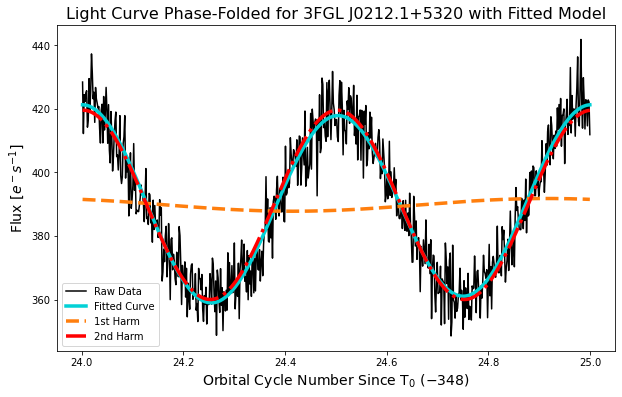

Phase Number: 26 

Fitted parameters: A=2.713547060736912, B=0.8697868598367188, C=4.480454377365006, D=30.25394422335588, E=6.283185306142186, F=388.75459124384344

Reduced χ2: 0.6547840339862415 



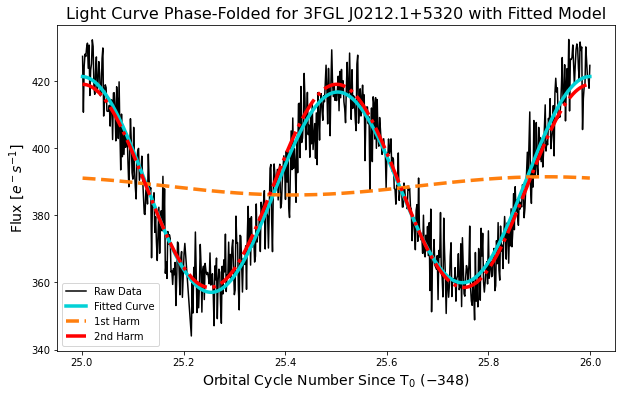

Phase Number: 27 

Fitted parameters: A=2.6919459268514423, B=0.8697855758875815, C=5.6380744152968525, D=30.581544650708587, E=6.283144169498574, F=391.12924118042554

Reduced χ2: 0.7138754843385674 



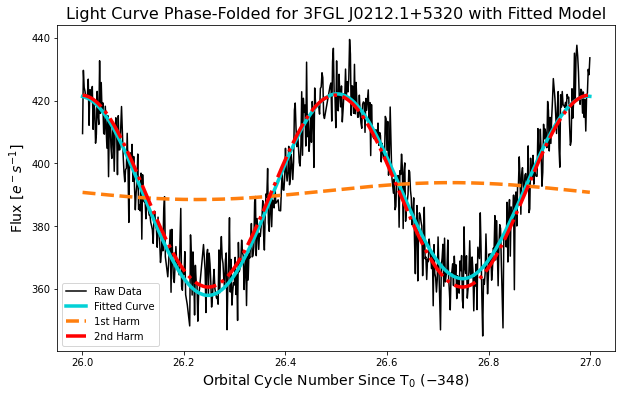

Phase Number: 28 

Fitted parameters: A=188.7788067845455, B=0.8696075477347089, C=0.19703687663665162, D=84.73645343868694, E=1.6997796757466832, F=265.53848604203995

Reduced χ2: 0.8330600153880212 



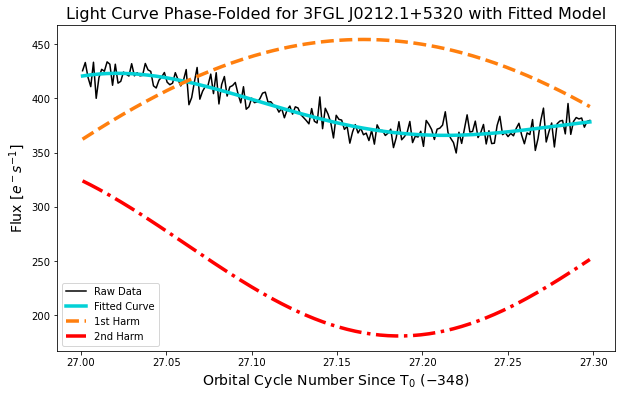

In [332]:
# Finds the number of phase cycles available from the tidied data 
n_cycles = int(((nan_tidied_time[-1]) - (nan_tidied_time[0])) / P) + 1

#Defining the test function
def test_func(x, A, B, C, D, E, F):
    return (A * np.sin(2*np.pi/B * x + C)) + (D * np.sin(4*np.pi/B * x + E)) + F

# First harmonic
def test_func_1(x, A, B, C, F):
    return (A * np.sin(2*np.pi/B * x + C)) + F

# Second harmonic
def test_func_2(x, B, D, E, F):
    return (D * np.sin(4*np.pi/B * x + E)) + F

A = 4 
B = P
C = 1 
D = 16 
E = 1 
F = averageflux 

init_vals = [A,B,C,D,E,F]

# Creates an array to store the reduced chi square values
reduced_chi_squared = []


# Creates a custom color map for the heatmap (pcolormesh). I found values for the colours of ["blue near black","mid range blue","blue near white"]
custom_cmap = LinearSegmentedColormap.from_list("custom", ["#011B31", "#058CFB", "#DDF0FF"])


# Loops through each phase cycle available in the data
for cycle in range(n_cycles):
    # Try and Except present as precaution for any data section that optimize.curve_fit can't find optimal parameters for
    try:
        # Selects section of data (the phase) to analyse
        start = T0_alt + cycle*P
        end = T0_alt + (cycle + 1)*P
        mask = (nan_tidied_time >= start) & (nan_tidied_time < end)
        
        #Creates the arrays for this phase from our nan_tidied data (s_ stands for section)
        s_nan_tidied_time = nan_tidied_time[mask]
        s_nan_tidied_flux = nan_tidied_flux[mask]   
        s_nan_tidied_errors = nan_tidied_errors[mask]
        phase_cycle = phase[mask]                                 
    
        #Uses our test function with scipy's optimize.curve_fit to create a model for this phase
        params, params_covariance = optimize.curve_fit(test_func, s_nan_tidied_time, s_nan_tidied_flux, init_vals, s_nan_tidied_errors,maxfev=10000, bounds = ([0,0,0,0,0,0],[np.inf,np.inf,2*np.pi,np.inf,2*np.pi,np.inf]) )
        s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit = params
        

        #Prints out the phase number (since T0_alt) and the fit parameters 
        print("Phase Number:",cycle+1,"\n")
        print(f"Fitted parameters: A={s_A_fit}, B={s_B_fit}, C={s_C_fit}, D={s_D_fit}, E={s_E_fit}, F={s_F_fit}\n")
    
        #Creates an array for the test model
        y_fit = test_func(s_nan_tidied_time, s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit)
        y_fit_1 = test_func_1(s_nan_tidied_time, s_A_fit, s_B_fit, s_C_fit,s_F_fit)
        y_fit_2 = test_func_2(s_nan_tidied_time, s_B_fit, s_D_fit, s_E_fit, s_F_fit)
        
        #Finds the reduced chi**2 of the model
        r_chi_squared = (np.sum(((s_nan_tidied_flux-y_fit)/(s_nan_tidied_errors))**2))/(len(y_fit)-num_params)
        reduced_chi_squared = np.append(reduced_chi_squared, r_chi_squared)
        print("Reduced \u03C72:",r_chi_squared,"\n")
        
        #Plots the time vs flux of the real data, and the time vs the model data
        plt.figure(figsize=(10, 6))
        plt.plot(phase_cycle, s_nan_tidied_flux, label="Raw Data", color='k')
        plt.plot(phase_cycle, y_fit, label="Fitted Curve", color='#02D1D6', lw=3.5)
        plt.plot(phase_cycle, y_fit_1,'C1--', label="1st Harm", lw=3.5)
        plt.plot(phase_cycle, y_fit_2,'r-.', label="2nd Harm", lw=3.5)
        plt.xlabel(xlabel, size=14)
        plt.ylabel(ylabel, size=14)
        plt.title("Light Curve Phase-Folded for " + str(system_name) + " with Fitted Model", size=16)
        plt.legend()
        plt.show()
        
        

    except:
        # Except case for any optimize.curve_fit that can't find optimal parameters 
        print("Phase Number:",cycle+1,"\n")
        print("RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 10000, for cycle number:",cycle+1,"\n")

        # Keeps r_c_s array the same length as array it will be plot with 
        reduced_chi_squared = np.append(reduced_chi_squared, 0)
        
        # Plots the real data for the phase        
        plt.plot(phase_cycle, s_nan_tidied_flux, label="Raw Data", color='k')
        plt.title("Raw Data with NO fit")
        plt.legend()
        plt.show()


#### Creating arrays for future plot analysis:

In [333]:
# This cell does similar to the one above in terms of its looping, but instead of plotting it is now appending each of the
# fit parameters and the phase number to the arrays defined for them for future plotting and analysis
init_vals = [A,B,C,D,E,F]

A_params = []
B_params = []
C_params = []
D_params = []
E_params = []
F_params = []
A_cov_params = []
B_cov_params = []
C_cov_params = []
D_cov_params = []
E_cov_params = []
F_cov_params = []
Cycle_Number = []

# Loops through each phase cycle available in the data
for cycle in range(n_cycles):
    # Try and Except present as precaution for any data section that optimize.curve_fit can't find optimal parameters for
    try:
        # Selects section of data (the phase) to analyse
        start = T0_alt + cycle*P
        end = T0_alt + (cycle + 1)*P
        mask = (nan_tidied_time >= start) & (nan_tidied_time < end)
        
        #Creates the arrays for this phase from our nan_tidied data (s_ stands for section)
        s_nan_tidied_time = nan_tidied_time[mask]
        s_nan_tidied_flux = nan_tidied_flux[mask]   
        s_nan_tidied_errors = nan_tidied_errors[mask]
    
        #Uses our test function with scipy's optimise.curve_fit to create a model for this phase
        params, params_covariance = optimize.curve_fit(test_func, s_nan_tidied_time, s_nan_tidied_flux, init_vals, s_nan_tidied_errors,maxfev=10000, bounds = ([0,0,0,0,0,0],[np.inf,np.inf,2*np.pi,np.inf,2*np.pi,np.inf]) ) 
        s_A_fit, s_B_fit, s_C_fit, s_D_fit, s_E_fit, s_F_fit = params
        s_A_cov, s_B_cov, s_C_cov, s_D_cov, s_E_cov, s_F_cov = params_covariance
        
        
        A_params = np.append(A_params, s_A_fit)
        B_params = np.append(B_params, s_B_fit)
        C_params = np.append(C_params, s_C_fit)
        D_params = np.append(D_params, s_D_fit)
        E_params = np.append(E_params, s_E_fit)
        F_params = np.append(F_params, s_F_fit)
        A_cov_params = np.append(A_cov_params, s_A_cov[0])
        B_cov_params = np.append(B_cov_params, s_B_cov[1])
        C_cov_params = np.append(C_cov_params, s_C_cov[2])
        D_cov_params = np.append(D_cov_params, s_D_cov[3])
        E_cov_params = np.append(E_cov_params, s_E_cov[4])
        F_cov_params = np.append(F_cov_params, s_F_cov[5])
        Cycle_Number = np.append(Cycle_Number, cycle+1)
        
    except:
        A_params = np.append(A_params, 0)
        B_params = np.append(B_params, 0)
        C_params = np.append(C_params, 0)
        D_params = np.append(D_params, 0)
        E_params = np.append(E_params, 0)
        F_params = np.append(F_params, 0)
        A_cov_params = np.append(A_cov_params, 0)
        B_cov_params = np.append(B_cov_params, 0)
        C_cov_params = np.append(C_cov_params, 0)
        D_cov_params = np.append(D_cov_params, 0)
        E_cov_params = np.append(E_cov_params, 0)
        F_cov_params = np.append(F_cov_params, 0)        
        Cycle_Number = np.append(Cycle_Number, cycle+1)


#### Plots of each fit parameter (and the reduced chi squared values) versus orbital cycle number:

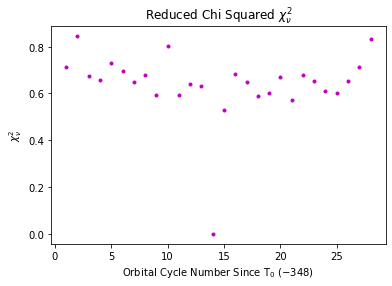

Mean Value for Reduced Chi Squared: 0.6409377840891731


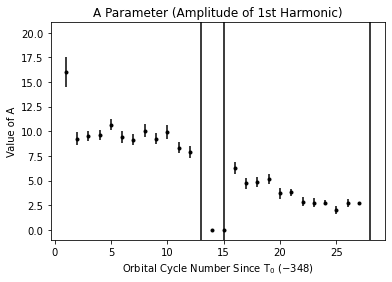

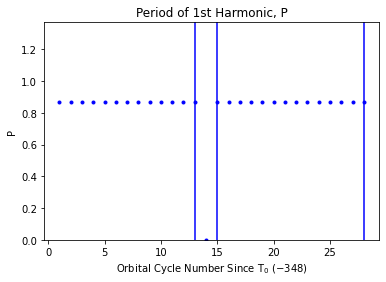

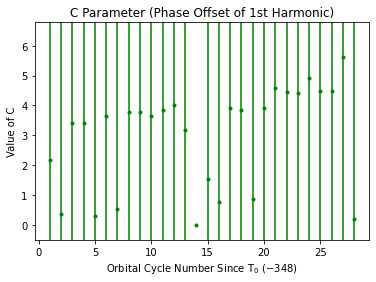

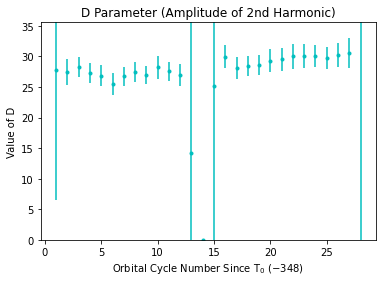

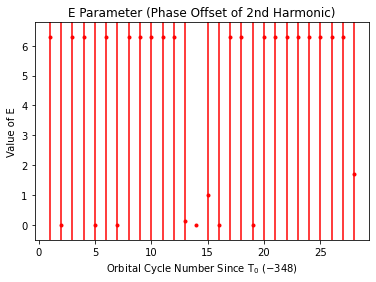

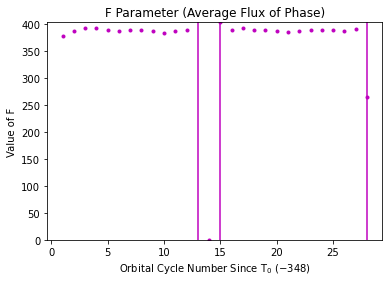

In [334]:
# This cell plots: * The reduced chi squared values of each phase
#                  * The fit parameters of each phase, all on separate plots.

plt.plot(Cycle_Number, reduced_chi_squared, color='m',marker='.',linestyle='')
plt.title(r"Reduced Chi Squared $\chi_\nu^2$")
plt.ylabel(r"$\chi_\nu^2$")
plt.xlabel(xlabel)
plt.show()

print("Mean Value for Reduced Chi Squared:",np.mean(reduced_chi_squared))


# Some parameter's errors contain very large values, so these ones have filters to create new limit arrays to constrain
# what values are visible in the plot (we don't need to look at the very large errors because these are for
# incomplete phase data sections)

# Creating arrays for y-axis limits
A_limits = []
B_limits = []
D_limits = []
F_limits = []


# Any values with an error value > 5 is cut off of the plot. This was done for A,B,D, and F. The limits for C and E, the phase offsets is more straightforward due to them being constarined to [0,2pi]
for i in range(len(A_cov_params)):
    if A_cov_params[i] < 5:
        A_limits = np.append(A_limits, A_params[i])
        
plt.errorbar(Cycle_Number, A_params, yerr=A_cov_params, fmt='k.', ecolor='k')
plt.ylim(-1, np.max(A_limits) + 5)
plt.ylabel("Value of A")
plt.xlabel(xlabel)
plt.title("A Parameter (Amplitude of 1st Harmonic)")
plt.show()

for i in range(len(B_cov_params)):
    if B_cov_params[i] < 5:
        B_limits = np.append(B_limits, B_params[i])

plt.errorbar(Cycle_Number, B_params, yerr=B_cov_params, fmt='b.', ecolor='b')
plt.ylim(0, np.max(B_limits) + 0.5)
plt.ylabel("P")
plt.xlabel(xlabel)
plt.title("Period of 1st Harmonic, P")
plt.show()


plt.errorbar(Cycle_Number, C_params, yerr=C_cov_params, fmt='g.', ecolor='g') 
plt.ylim(- 0.5,2*np.pi + 0.5)
plt.ylabel("Value of C")
plt.xlabel(xlabel)
plt.title("C Parameter (Phase Offset of 1st Harmonic)")
plt.show()


for i in range(len(D_cov_params)):
    if D_cov_params[i] < 5:
        D_limits = np.append(D_limits, D_params[i])
        
plt.errorbar(Cycle_Number, D_params, yerr=D_cov_params, fmt='c.', ecolor='c') 
plt.ylim(0, np.max(D_limits) + 5)
plt.ylabel("Value of D")
plt.xlabel(xlabel)
plt.title("D Parameter (Amplitude of 2nd Harmonic)")
plt.show()

plt.errorbar(Cycle_Number, E_params, yerr=E_cov_params, fmt='r.', ecolor='r')
plt.ylim(- 0.5,2*np.pi + 0.5)
plt.ylabel("Value of E")
plt.xlabel(xlabel)
plt.title("E Parameter (Phase Offset of 2nd Harmonic)")
plt.show()

for i in range(len(F_cov_params)):
    if F_cov_params[i] < 5:
        F_limits = np.append(F_limits, F_params[i])

plt.errorbar(Cycle_Number, F_params, yerr=F_cov_params, fmt='m.', ecolor='m')
plt.ylim(0, np.max(F_limits) + 10)
plt.ylabel("Value of F")
plt.xlabel(xlabel)
plt.title("F Parameter (Average Flux of Phase)")
plt.show()

## Analysing the fit parameters more closely

If any periodic pattern is noticed in the $A_1$ parameters in the graph above, then the below analysis can be done to test for star spots.

The cell below will plot the A1 and $\phi_1$ parameters, fitting a sine model to the $A_1$ parameters, and allowing a closer look at the behaviour of $\phi_1$. It automatically excludes any values where the error in $A_1$ was > 5 *and* any remaining values greater than 2 times the mean of what remained.

Fitted parameters for sine curve: A=3.6926235364332305, B=40.02395712427371, C=0.6767216389439523, D=6.196582005374023 



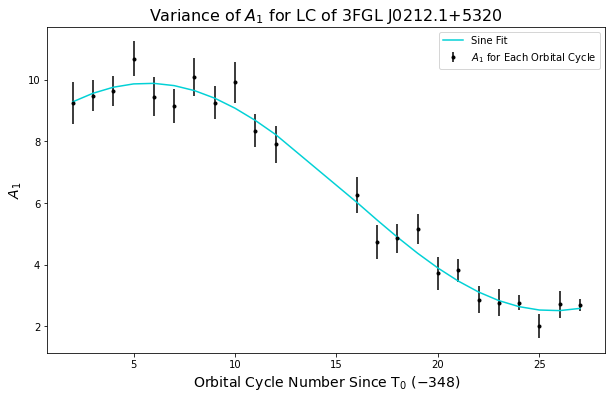

0.9135898175775143


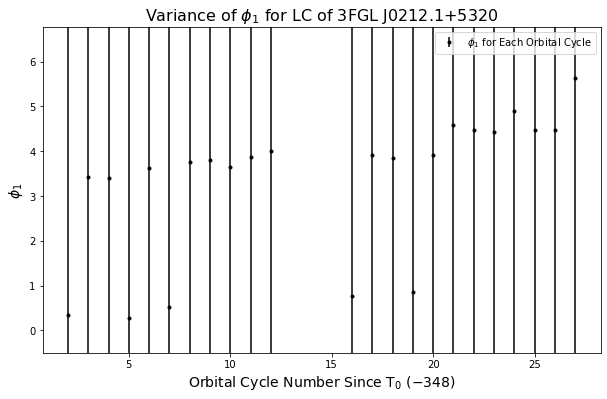

In [335]:
A_params_new = []
A_params_new_mid = []
A_cov_params_new = []

Cycle_number_new = []

C_params_new = []
C_params_new_mid = []
C_cov_params_new = []

# Removes any values from each array where the error of A1 is 0 or greater than 5 
for i in range(len(A_cov_params)):
    if (0 < A_cov_params[i] <= 5):
        A_cov_params_new = np.append(A_cov_params_new, A_cov_params[i])
        Cycle_number_new = np.append(Cycle_number_new, Cycle_Number[i])
        A_params_new_mid = np.append(A_params_new_mid, A_params[i])
        C_params_new_mid = np.append(C_params_new_mid, C_params[i])
        C_cov_params_new = np.append(C_cov_params_new, C_cov_params[i])

# Deals with any remaining values where the error was within the above window, but the value itself is an outlier > 2*mean
A_params_new = A_params_new_mid[A_params_new_mid < 2*np.mean(A_params_new_mid)]
Cycle_number_new = Cycle_number_new[A_params_new_mid < 2*np.mean(A_params_new_mid)]
A_cov_params_new = A_cov_params_new[A_params_new_mid < 2*np.mean(A_params_new_mid)]

C_params_new = C_params_new_mid[A_params_new_mid < 2*np.mean(A_params_new_mid)]
C_cov_params_new = C_cov_params_new[A_params_new_mid < 2*np.mean(A_params_new_mid)]

#Defining the test function
def test_func(x, A, B, C, D):
    return (A * np.sin(2*np.pi/(B) * x + C)) + D

averageflux = np.mean(nan_tidied_flux)

A = np.mean(A_params_new)
B = 40
C = 1
D = np.mean(A_params_new)

init_vals = [A,B,C,D]

params, params_covariance = optimize.curve_fit(test_func, Cycle_number_new, A_params_new, init_vals)

A_fit, B_fit, C_fit, D_fit = params
A_cov, B_cov, C_cov, D_cov = params_covariance

print(f"Fitted parameters for sine curve: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit} \n")

# Uses the best fit parameters to create the test model
y_fit = test_func(Cycle_number_new, A_fit, B_fit, C_fit, D_fit)


# Plots the A1 parameters with the sine fit model
plt.figure(figsize=(10, 6))
plt.plot(Cycle_number_new, y_fit, label="Sine Fit", color='#02D1D6')
plt.errorbar(Cycle_number_new, A_params_new, yerr=A_cov_params_new, fmt='k.', ecolor='k', label=r"$A_1$ for Each Orbital Cycle")
plt.title(r"Variance of $A_1$ for LC of " + str(system_name), size=16 )
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel, size =14)
plt.ylabel(r"$A_1$", size=14)

plt.legend()
plt.show()

r_chi_squared = (np.sum(((A_params_new-y_fit)/(A_cov_params_new))**2))/(len(y_fit)-num_params)
print(r_chi_squared)

# Plots the C parameters 
plt.figure(figsize=(10, 6))
plt.errorbar(Cycle_number_new, C_params_new, yerr=C_cov_params_new, fmt='k.', ecolor='k', label=r"$\phi_1$ for Each Orbital Cycle")
plt.title(r"Variance of $\phi_1$ for LC of " + str(system_name), size=16 )
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel, size =14)
plt.ylabel(r"$\phi_1$", size=14)
plt.ylim(- 0.5,2*np.pi + 0.5)


plt.legend()
plt.savefig("J0212Phi1.pdf")
plt.show()

Approximating the size of the spot. The result is a percentage of visible stellar surface covered by the spot.

Required inputs from user:

In [336]:
T_stellar = 6000    # Temperature of the main surface of the companion star [K]

T_spot = T_stellar - 500    # Temperature of the spot estimated to be 500 K less than T_stellar [5]

flux_peak_to_peak = 95     # This is a rough "by eye" guess of the overall flux peak to peak of the full lightcurve

In [337]:
A_spot_over_A_stellar = ( (2*A_fit)/flux_peak_to_peak ) / (1 - (T_spot/T_stellar)**4 )
print("The approximate spot coverage percentage of the stellar surface is: ", 100*A_spot_over_A_stellar)

The approximate spot coverage percentage of the stellar surface is:  26.447991589820624


Below here is the rougher manual process followed to obtain what we got from the automatic version above. This is left here to be followed in case the automatic version is not as robust as desired. There are also cells that will plot the desired parameter results for $A_1$, $A_2$, and $\phi_1$ for J0212 or J0523.

In [72]:
# Looking through the A1 parameters to see which ones we want to exclude from analysis
i=0
for i in range(len(A_params)):
    print(i, "=", A_params[i])
print("Errors")
for i in range(len(A_cov_params)):
    print(i, "=", A_cov_params[i])


0 = 9518.803220130434
1 = 1.8604666337078117
2 = 0.9423544582388674
3 = 1.2691159882748395
4 = 1.729439968385651
5 = 2.1069393822031435
6 = 1.67647317803297
7 = 1.994949986168543
8 = 1.8165559535458267
9 = 1.702939644285738
10 = 1.9003865446634691
11 = 0.9790665135982561
12 = 1.347141869031368
13 = 1.5509733615139876
14 = 1.3141266205177562
15 = 1.270107570509868
16 = 1.3090803841781629
17 = 1.6561102296894055
18 = 145.11324628845585
19 = 0.0
20 = 2.2494256410207836
21 = 1.4620725046527772
22 = 1.7234710280049836
23 = 1.6593335781713936
24 = 1.0626733667023633
25 = 1.6973047423567174
26 = 1.708637872681902
27 = 2.097479670716329
28 = 1.7247596051914396
29 = 2.0753144636964396
30 = 1.5252190970014916
31 = 1.7244115981115555
32 = 1.4635916422990838
33 = 1.7446286301869338
34 = 1.7293598057357729
35 = 1.7571304858528547
36 = 1.8752070083749572
37 = 2.051122526447657
ERRors
0 = 5010139082.789174
1 = 0.22403016697732595
2 = 0.30371751052713203
3 = 0.2028348291306198
4 = 0.17758174430710222


In [73]:
# Compared that to D (A2) to see if similar/ the same ith elements of the arrays would be excluded.
i=0
for i in range(len(D_params)):
    print(i, "=", D_params[i])
print("Errors")
for i in range(len(D_cov_params)):
    print(i, "=", D_cov_params[i])

0 = 2447.7707429853917
1 = 6.224048081754538
2 = 7.723062772033501
3 = 7.069493618323675
4 = 6.7284799943394455
5 = 7.29896167144304
6 = 6.285927007714861
7 = 6.859670684461153
8 = 6.766486406412532
9 = 7.148057127115802
10 = 7.067898531855836
11 = 6.774821303507771
12 = 6.2310609897386815
13 = 6.793492841243007
14 = 6.510124244306093
15 = 6.977340440004835
16 = 7.183928235458058
17 = 6.974555286091204
18 = 75.2162587625581
19 = 0.0
20 = 5.019558149050346
21 = 7.434137184864757
22 = 6.928155546995751
23 = 6.537790173703381
24 = 6.279998671838629
25 = 6.8255911767849815
26 = 6.4726358737704714
27 = 6.03690635333515
28 = 6.854218189452286
29 = 6.149445847692605
30 = 6.9879702938576385
31 = 7.377708077020926
32 = 6.567357790093641
33 = 6.496235676241347
34 = 6.7346699973347794
35 = 6.902129794722423
36 = 7.049437899268094
37 = 5.960014057918247
ERRors
0 = 1268425134.3520172
1 = 2.4231899140482502
2 = 2.3482735885048127
3 = 2.2158612911672284
4 = 2.0676366673071422
5 = 2.9855523329056117
6

For J0212, we don't want values i = 0,12,13,14,27. For J0523, we don't want values i = 0,18,19,20

Fitted parameters for sine curve: A=-13.981651107706837, B=21.127176179241822, C=-0.605630424478691, D=9.950093405391495 



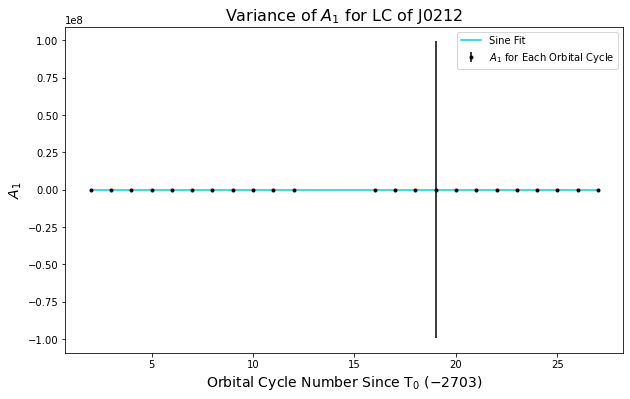

In [74]:
A_params_new = []
Cycle_number_new = []
A_cov_params_new = []
F_params_new = []

#J0212
for i in (1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24,25,26):
    A_params_new = np.append(A_params_new, A_params[i])
    Cycle_number_new = np.append(Cycle_number_new, Cycle_Number[i])
    A_cov_params_new = np.append(A_cov_params_new, A_cov_params[i])
    F_params_new = np.append(F_params_new, F_params[i])

#J0523
#for i in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37):
#    A_params_new = np.append(A_params_new, A_params[i])
#    Cycle_number_new = np.append(Cycle_number_new, Cycle_Number[i])
#    A_cov_params_new = np.append(A_cov_params_new, A_cov_params[i])

#Defining the test function
def test_func(x, A, B, C, D):
    return (A * np.sin(2*np.pi/(B) * x + C)) + D

averageflux = np.mean(nan_tidied_flux)

#A = 1
B = 40
C = 1
D = averageflux

A = np.mean(A_params_new)
#B = 40
#C = np.mean(C_params_new)
#D = averageflux

init_vals = [A,B,C,D]

params, params_covariance = optimize.curve_fit(test_func, Cycle_number_new, A_params_new, init_vals)

A_fit, B_fit, C_fit, D_fit = params
A_cov, B_cov, C_cov, D_cov = params_covariance

print(f"Fitted parameters for sine curve: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit} \n")

# Uses the best fit parameters to create the test model
y_fit = test_func(Cycle_number_new, A_fit, B_fit, C_fit, D_fit)

plt.figure(figsize=(10, 6))
plt.plot(Cycle_number_new, y_fit, label="Sine Fit", color='#02D1D6')
plt.errorbar(Cycle_number_new, A_params_new, yerr=A_cov_params_new, fmt='k.', ecolor='k', label=r"$A_1$ for Each Orbital Cycle")
plt.title(r"Variance of $A_1$ for LC of J0212", size=16)
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel, size=14)
plt.ylabel(r"$A_1$", size=14)

plt.legend()
plt.show()

In [75]:
A_spot_over_A_stellar = ( (2*(3.692623547446929))/95.0 ) / (1 - (5500.0/6000.0)**4)
print(A_spot_over_A_stellar)

0.2644799166870498


In [76]:
print(A_cov)

[ 83.41406625   2.12249759   0.13227755 -14.61235273]


In [ ]:
B_cov[1] * P

Testing C (phase offset of first harmonic) parameters:

Fitted parameters for sine curve: A=-2074.1692616712307, B=-4209.018642785202, C=-4.725994119771101, D=2076.0735885895915 



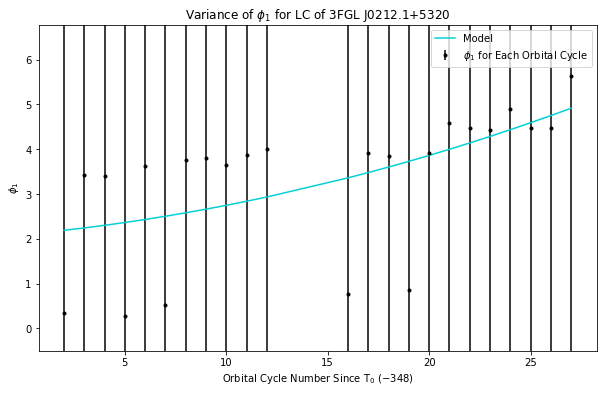

In [33]:
C_params_new = []
C_cov_params_new = []
#J0212
for i in (1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24,25,26):
    C_params_new = np.append(C_params_new, C_params[i])
    C_cov_params_new = np.append(C_cov_params_new, C_cov_params[i])

#J0523    
#for i in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37):
#    C_params_new = np.append(C_params_new, C_params[i])
#    C_cov_params_new = np.append(C_cov_params_new, C_cov_params[i])

#Defining the test function
def test_func(x, A, B, C, D):
    return (A * np.sin(2*np.pi/(B) * x + C)) + D

averageflux = np.mean(nan_tidied_flux)
#J0212
A = 1
B = 40
C = 1
D = averageflux
#J0523
#A = np.mean(A_params_new)
#B = 40
#C = np.mean(C_params_new)
#D = averageflux

init_vals = [A,B,C,D]

params, params_covariance = optimize.curve_fit(test_func, Cycle_number_new, C_params_new, init_vals)

A_fit, B_fit, C_fit, D_fit = params
A_cov, B_cov, C_cov, D_cov = params_covariance

print(f"Fitted parameters for sine curve: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit} \n")

# Uses the best fit parameters to create the test model
y_fit = test_func(Cycle_number_new, A_fit, B_fit, C_fit, D_fit)

plt.figure(figsize=(10, 6))

plt.plot(Cycle_number_new, y_fit, label="Model", color='#02D1D6')
plt.errorbar(Cycle_number_new, C_params_new, yerr=C_cov_params_new, fmt='k.', ecolor='k', label=r"$\phi_1$ for Each Orbital Cycle")
plt.title(r"Variance of $\phi_1$ for LC of "  + str(system_name) )
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel)
plt.ylabel(r"$\phi_1$")
plt.ylim(- 0.5,2*np.pi + 0.5)
plt.legend()
plt.show()


Testing D parameters (amplitude of second harmonic)

Fitted parameters for sine curve: A=-1.6384208956261754, B=41.1590781431294, C=0.5329145748134796, D=28.67209751699483 

Variance in D: 5.055401439819661


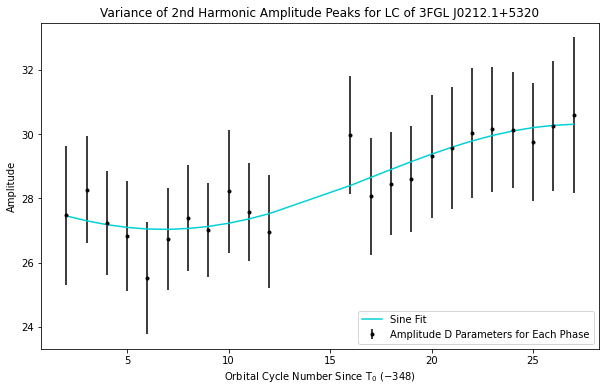

In [111]:
D_params_new = []
D_cov_params_new = []
#J0212
for i in (1,2,3,4,5,6,7,8,9,10,11,15,16,17,18,19,20,21,22,23,24,25,26):
    D_params_new = np.append(D_params_new, D_params[i])
    D_cov_params_new = np.append(D_cov_params_new, D_cov_params[i])
    
#J0523    
#for i in (1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37):
 #   D_params_new = np.append(D_params_new, D_params[i])
  #  D_cov_params_new = np.append(D_cov_params_new, D_cov_params[i])

#Defining the test function
def test_func(x, A, B, C, D):
    return (A * np.sin(2*np.pi/(B) * x + C)) + D

average_amp = np.mean(D_params_new)
#Random for A,C=1
#J0212
#A = 1
B = 40
#C = 1
#D = averageflux

#J0523
A = np.mean(A_params_new)
#B = 3.5
C = np.mean(C_params_new)
D = averageflux

init_vals = [A,B,C,D]
bounds = (-np.pi,(np.inf,np.inf,np.inf,np.inf))  ######## Breaks down when adding in the bounds, same as single sine model below

params, params_covariance = optimize.curve_fit(test_func, Cycle_number_new, D_params_new, init_vals)#, nan_tidied_errors)

A_fit, B_fit, C_fit, D_fit = params
A_cov, B_cov, C_cov, D_cov = params_covariance

print(f"Fitted parameters for sine curve: A={A_fit}, B={B_fit}, C={C_fit}, D={D_fit} \n")

print("Variance in D:", np.max(D_params_new) - np.min(D_params_new))

# Uses the best fit parameters to create the test model
y_fit = test_func(Cycle_number_new, A_fit, B_fit, C_fit, D_fit)

plt.figure(figsize=(10, 6))
plt.plot(Cycle_number_new, y_fit, label="Sine Fit", color='#02D1D6')
plt.errorbar(Cycle_number_new, D_params_new, yerr=D_cov_params_new, fmt='k.', ecolor='k', label="Amplitude D Parameters for Each Phase")
plt.title("Variance of 2nd Harmonic Amplitude Peaks for LC of " + str(system_name) )
xlabel = 'Orbital Cycle Number Since T$_0$ ($-' + str(N) + '$)'
plt.xlabel(xlabel)
plt.ylabel("Amplitude")

plt.legend(loc='lower right')
plt.show()


# References

[1] K. I. Perez, S. Bogdanov, J. P. Halpern, V. Gajjar, Green Bank Telescope Discovery of the Redback Binary Millisecond Pulsar PSR J0212+5321, *The Astrophysical Journal* **952** 150 (2023)

[2] J. Strader, L. Chomiuk, E. Sonbas, K. Sokolovsky, D. J. Sand, A. S. Moskvitin, C. C. Cheung, 1FGL J0523.5−2529: A NEW PROBABLE GAMMA-RAY PULSAR BINARY, *The Astrophysical Journal Letters*, **788** L27 (2014)

[3] J. Vanderplas, A. Connolly, Z. Ivezic, A. Gray,“ Introduction to astroML: Machine learning for astrophysics”, *Proceedings of the Conference on Intelligent Data Understanding 2012*, 47-54 (2012)

[4] J. Vanderplas, Z. Ivezic, “Periodograms for Multiband Astronomical Time Series”, *The Astrophysical Journal*, **812** 1:18 (2015)

[5] C. Clark, L. Nieder, G. Voisin, B. Allen, C. Aulbert, O. Behnke, R. Breton, C. Choquet, A. Corongiu, V. Dhillon, H. B. Eggenstein, H. Fehrmann, L. Guillemot, A. Harding, M. Kennedy, B. Machenschalk, T. Marsh, D. Sánchez, R. Mignani, J. Wu, “Einstein@Home discovery of the gamma-ray millisecond pulsar PSR J2039–5617 confirms its predicted redback nature”, *Monthly Notices of the Royal Astronomical Society*, **502** 915–934 (2021)